In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [2]:
transform = tfs.Compose([
    tfs.Resize(64),
    tfs.CenterCrop(64),
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [3]:
PortraitSet = ImageFolder('./img_jpg', transform = transform)
PortraitData = DataLoader(PortraitSet, batch_size = 128, shuffle = True, num_workers = 2)

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

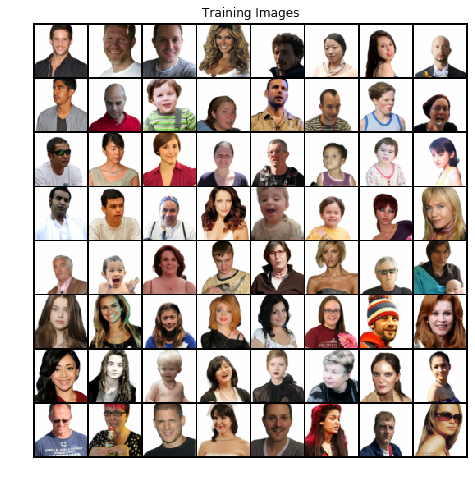

In [5]:
real_batch = next(iter(PortraitData))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
G_net = Generator().to(device)
D_net = Discriminator().to(device)
G_net = nn.DataParallel(G_net)
D_net = nn.DataParallel(D_net)
G_optim = torch.optim.Adam(G_net.parameters(), lr = 0.0002, betas = (0.5, 0.999))
D_optim = torch.optim.Adam(D_net.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [9]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1
fake_label = 0

In [10]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epo in range(10):
    for i, data in enumerate(PortraitData, 0):
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, device = device)
        output = D_net(real_data).view(-1)
        real_error = criterion(output, label)
        D_optim.zero_grad()
        real_error.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, 100, 1, 1,device = device)
        fake_data = G_net(noise)
        label.fill_(fake_label)
        output = D_net(fake_data.detach()).view(-1)
        fake_error = criterion(output, label)
        fake_error.backward()
        D_G_z1 = output.mean().item()
        err_D = real_error + fake_error
        D_optim.step()
        
        label.fill_(real_label)
        output = D_net(fake_data).view(-1)
        err_G = criterion(output, label)
        G_optim.zero_grad()
        err_G.backward()
        D_G_z2 = output.mean().item()
        G_optim.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epo, 10, i, len(PortraitData),
                     err_D.item(), err_G.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(err_G.item())
        D_losses.append(err_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epo == 10-1) and (i == len(PortraitData)-1)):
            with torch.no_grad():
                fake = G_net(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1        

[0/10][0/269]	Loss_D: 1.3804	Loss_G: 1.3365	D(x): 0.4702	D(G(z)): 0.4602 / 0.2656
[0/10][50/269]	Loss_D: 0.0053	Loss_G: 8.0758	D(x): 0.9955	D(G(z)): 0.0007 / 0.0004
[0/10][100/269]	Loss_D: 0.0621	Loss_G: 7.6625	D(x): 0.9499	D(G(z)): 0.0003 / 0.0005
[0/10][150/269]	Loss_D: 0.5885	Loss_G: 2.5976	D(x): 0.7931	D(G(z)): 0.2824 / 0.0798
[0/10][200/269]	Loss_D: 0.5841	Loss_G: 2.7490	D(x): 0.8000	D(G(z)): 0.2789 / 0.0756
[0/10][250/269]	Loss_D: 0.9157	Loss_G: 0.9977	D(x): 0.4992	D(G(z)): 0.1334 / 0.3931
[1/10][0/269]	Loss_D: 0.7443	Loss_G: 2.9129	D(x): 0.7776	D(G(z)): 0.3647 / 0.0627
[1/10][50/269]	Loss_D: 0.8555	Loss_G: 0.7673	D(x): 0.5001	D(G(z)): 0.0855 / 0.4860
[1/10][100/269]	Loss_D: 1.1415	Loss_G: 0.7965	D(x): 0.4018	D(G(z)): 0.1239 / 0.4656
[1/10][150/269]	Loss_D: 0.9529	Loss_G: 1.6820	D(x): 0.6113	D(G(z)): 0.3390 / 0.2014
[1/10][200/269]	Loss_D: 0.8773	Loss_G: 1.2265	D(x): 0.5639	D(G(z)): 0.2185 / 0.3105
[1/10][250/269]	Loss_D: 1.4100	Loss_G: 3.7231	D(x): 0.8575	D(G(z)): 0.6958 / 0.028

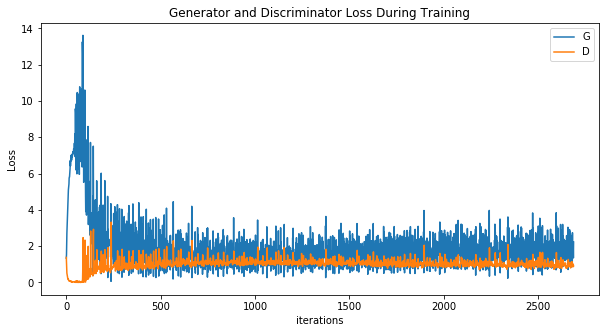

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

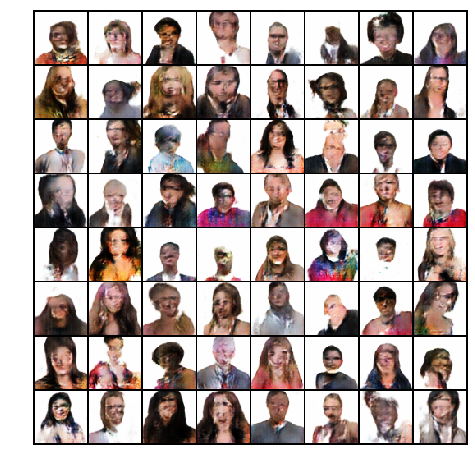

In [13]:
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

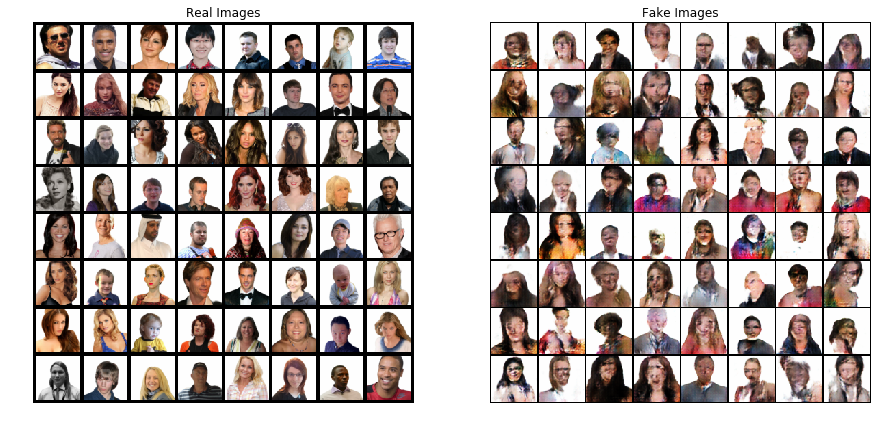

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(PortraitData))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()